In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm 

REBUILD_DATA = True

In [2]:
class cells():
    IMG_SIZE = 50
    PARASITIZED = "Parasitized"
    UNINFECTED = "Uninfected"
    LABELS = {PARASITIZED : 0, UNINFECTED : 1}
    
    training_data = []
    badcount = 0
    goodcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.PARASITIZED:
                        self.badcount += 1
                    elif label == self.UNINFECTED:
                        self.goodcount += 1
                        
                except Exception as e:
                    pass
                    #print(str(e))
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        
        print("Parasitized: ", self.badcount)
        print("Uninfected: ", self.goodcount)


In [3]:
if REBUILD_DATA:
    data = cells()
    data.make_training_data()

Parasitized


  0%|          | 0/733 [00:00<?, ?it/s]

Uninfected


100%|██████████| 733/733 [00:13<00:00, 54.60it/s]
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Parasitized:  1629
Uninfected:  733


In [4]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [5]:
print(len(training_data))

2362


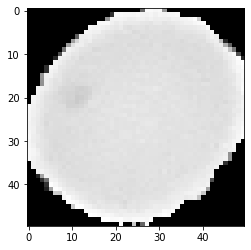

In [6]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2,))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2,))
        
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    

net = Net()
            

[2020-12-13 16:32:23.926 pytorch-1-6-cpu-py36--ml-t3-medium-016478e629f45c0d047785aeb907:98 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2020-12-13 16:32:24.120 pytorch-1-6-cpu-py36--ml-t3-medium-016478e629f45c0d047785aeb907:98 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
torch.Size([128, 2, 2])


In [9]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)

loss_function = nn.MSELoss() 

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

print(val_size)

236


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

2126
236


In [17]:
BATCH_SIZE = 100

EPOCHS = 7

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

  5%|▍         | 1/22 [00:00<00:05,  3.88it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:05,  3.88it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  3.86it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:01<00:04,  3.69it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  3.73it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:04,  3.85it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  3.90it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:02<00:03,  3.99it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.03it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.06it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.08it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:03<00:02,  4.10it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.00it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.05it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.10it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:04<00:01,  4.11it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:04<00:01,  4.12it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.14it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.17it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.17it/s]

torch.Size([128, 2, 2])


  0%|          | 0/22 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:04,  4.44it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:04,  4.44it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  4.28it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:00<00:04,  4.17it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  4.16it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:03,  4.09it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  4.00it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:01<00:03,  3.99it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.04it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.09it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.19it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.23it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.28it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.24it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.10it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.00it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:04<00:01,  4.05it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.02it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.10it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.20it/s]

torch.Size([128, 2, 2])


  0%|          | 0/22 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:05,  4.00it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:05,  4.00it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  4.11it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:00<00:04,  4.08it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  4.10it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:03,  4.07it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  4.09it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:01<00:03,  4.20it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.25it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.27it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.26it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.15it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.05it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.16it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.24it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.30it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:04<00:01,  4.32it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.29it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.17it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.10it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 21/22 [00:05<00:00,  4.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:05,  3.99it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:04,  4.00it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  3.97it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:00<00:04,  4.02it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  4.14it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:03,  4.24it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  4.22it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:01<00:03,  4.27it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:02,  4.33it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.38it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.43it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.41it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.25it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.26it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.33it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.38it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:03<00:01,  4.44it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.47it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.48it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.46it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 21/22 [00:04<00:00,  4.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:05,  4.17it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:04,  4.13it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  4.19it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:00<00:04,  4.18it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  4.19it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:03,  4.19it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  4.21it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:01<00:03,  4.30it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.24it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.33it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.37it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.36it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.27it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.30it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.34it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.35it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:03<00:01,  4.38it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.40it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.37it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.34it/s]

torch.Size([128, 2, 2])


  0%|          | 0/22 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:05,  4.06it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:04,  4.06it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  4.04it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:00<00:04,  4.05it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  3.99it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:03,  4.13it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  4.25it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:01<00:03,  4.25it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.17it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.21it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.30it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.35it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.34it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.27it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.20it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.21it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:04<00:01,  4.30it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:00,  4.28it/s]

torch.Size([128, 2, 2])


 86%|████████▋ | 19/22 [00:04<00:00,  4.27it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:04<00:00,  4.32it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 21/22 [00:04<00:00,  4.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 1/22 [00:00<00:05,  3.85it/s]

torch.Size([128, 2, 2])


  9%|▉         | 2/22 [00:00<00:05,  3.89it/s]

torch.Size([128, 2, 2])


 14%|█▎        | 3/22 [00:00<00:04,  3.87it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 4/22 [00:01<00:04,  3.92it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 5/22 [00:01<00:04,  3.99it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 6/22 [00:01<00:04,  3.98it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 7/22 [00:01<00:03,  3.93it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 8/22 [00:02<00:03,  3.97it/s]

torch.Size([128, 2, 2])


 41%|████      | 9/22 [00:02<00:03,  4.02it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 10/22 [00:02<00:02,  4.09it/s]

torch.Size([128, 2, 2])


 50%|█████     | 11/22 [00:02<00:02,  4.19it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 12/22 [00:02<00:02,  4.26it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 13/22 [00:03<00:02,  4.31it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 14/22 [00:03<00:01,  4.29it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 15/22 [00:03<00:01,  4.13it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 16/22 [00:03<00:01,  4.02it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 17/22 [00:04<00:01,  3.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 18/22 [00:04<00:01,  3.47it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 20/22 [00:05<00:00,  3.38it/s]

torch.Size([128, 2, 2])


100%|██████████| 22/22 [00:05<00:00,  4.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
tensor(0.0069, grad_fn=<MseLossBackward>)


In [16]:
correct = 0 
total = 0 

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy", round(correct/total,3))

 17%|█▋        | 41/236 [00:00<00:00, 401.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 33%|███▎      | 77/236 [00:00<00:00, 234.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 145/236 [00:00<00:00, 225.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 97%|█████████▋| 229/236 [00:00<00:00, 293.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 236/236 [00:00<00:00, 281.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy 0.89
